# Forecast skill 

This notebook contains a summary of some skill results to date. Results are shown for CAFE-f6 and for the CanESM5 and EC-Earth3 CMIP6 DCPP submissions. 30-year climatological and verification periods are used for both the CAFE-f6 and CMIP6 data. However, because the historical CMIP6 data end in 2014, these periods differ slightly: 1991-2020 for CAFE-f6; 1985-2014 for CanESM5 and EC-Earth3.

In [2]:
import cftime

import xarray as xr
import xskillscore as xs

import matplotlib.pyplot as plt

from src import plot

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [25]:
SKILL_DIR = "../../data/skill/"
CAFE_PERIOD = "1991-2020"
CMIP_PERIOD = "1985-2014"

In [32]:
def load_skill(hindcast, reference, timescale, variable, metric):
    """Load a skill metric"""
    if hindcast == "CAFEf6":
        period = CAFE_PERIOD
    else:
        period = CMIP_PERIOD
    return xr.open_zarr(
        f"{SKILL_DIR}/{hindcast}.{reference}.{timescale}.anom_{period}.{variable}.{metric}_{period}.zarr"
    ).compute()

## Sea surface temperature
### Anomaly correlation coefficient  |  HadISST

In [ ]:
metric = "rXY"
variable = "sst"
reference = "HadISST"

f6_annual_rXY = load_skill("CAFEf6", reference, "annual", variable, metric)
f6_4year_rXY = load_skill("CAFEf6", reference, "4-year", variable, metric)

can_annual_rXY = load_skill("CanESM5", reference, "annual", variable, metric)
can_4year_rXY = load_skill("CanESM5", reference, "4-year", variable, metric)

ec_annual_rXY = load_skill("EC_Earth3", reference, "annual", variable, metric)
ec_4year_rXY = load_skill("EC_Earth3", reference, "4-year", variable, metric)

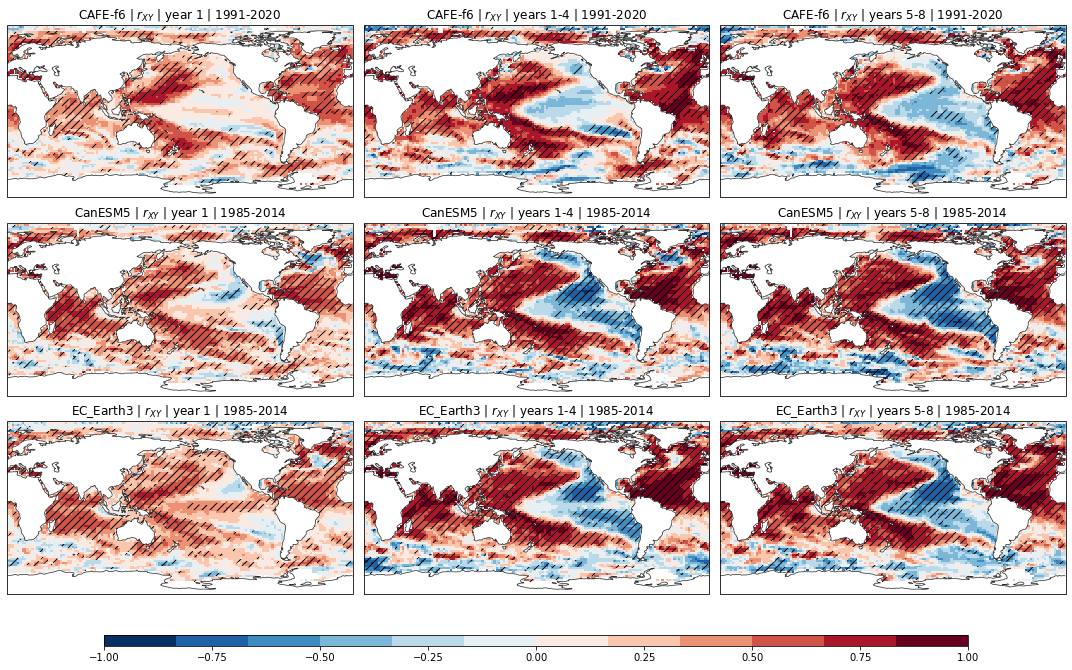

In [8]:
metric = "$r_{XY}$"

_ = plot.skill_maps(
    [
        [
            f6_annual_rXY.sel(lead=23),
            f6_4year_rXY.sel(lead=59),
            f6_4year_rXY.sel(lead=107),
        ],
        [
            can_annual_rXY.sel(lead=23),
            can_4year_rXY.sel(lead=59),
            can_4year_rXY.sel(lead=107),
        ],
        [
            ec_annual_rXY.sel(lead=23),
            ec_4year_rXY.sel(lead=59),
            ec_4year_rXY.sel(lead=107),
        ],
    ],
    variable="sst",
    vrange=(-1, 1),
    headings=[
        [
            f"CAFE-f6 | {metric} | year 1",
            f"CAFE-f6 | {metric} | years 1-4",
            f"CAFE-f6 | {metric} | years 5-8",
        ],
        [
            f"CanESM5 | {metric} | year 1",
            f"CanESM5 | {metric} | years 1-4",
            f"CanESM5 | {metric} | years 5-8",
        ],
        [
            f"EC_Earth3 | {metric} | year 1",
            f"EC_Earth3 | {metric} | years 1-4",
            f"EC_Earth3 | {metric} | years 5-8",
        ],
    ],
)

#### What are those big patches of negative correlation in the Pacific the 4-year averages?
These aren't apparent in the CanESM5 verification paper. Are they an artifact of differing "trends" over the short verifcation period? Let's look at the skill of CanESM5 and EC_Earth3 over a longer (1969-2020) period of time

In [9]:
can_4year_rXY = xr.open_zarr(
    f"{SKILL_DIR}/CanESM5.HadISST.4-year.anom_1985-2014.sst.rXY_1969-2020.zarr"
).compute()

ec_4year_rXY = xr.open_zarr(
    f"{SKILL_DIR}/EC_Earth3.HadISST.4-year.anom_1985-2014.sst.rXY_1969-2020.zarr"
).compute()

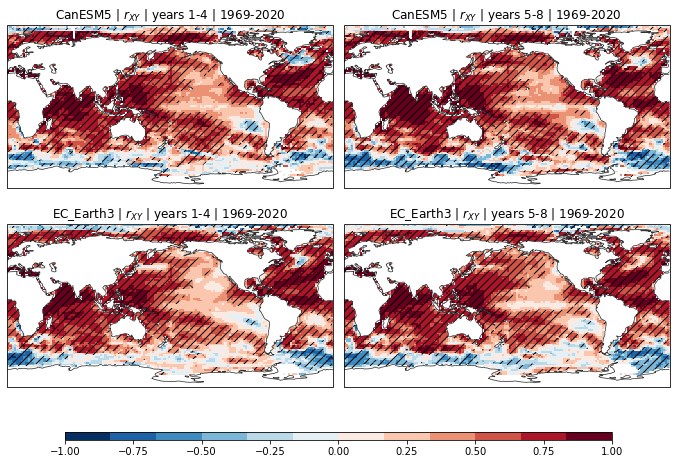

In [10]:
metric = "$r_{XY}$"

_ = plot.skill_maps(
    [
        [can_4year_rXY.sel(lead=59), can_4year_rXY.sel(lead=107)],
        [ec_4year_rXY.sel(lead=59), ec_4year_rXY.sel(lead=107)],
    ],
    variable="sst",
    vrange=(-1, 1),
    headings=[
        [f"CanESM5 | {metric} | years 1-4", f"CanESM5 | {metric} | years 5-8"],
        [f"EC_Earth3 | {metric} | years 1-4", f"EC_Earth3 | {metric} | years 5-8"],
    ],
    figsize=(9.5, 7),
)

This looks more like the results in the CanESM5 verification paper. So we need to be pretty careful interpretting the anomaly correlation coefficient over out short verification period. Let's demonstrate this by looking at the hindcast and observed timeseried at a location in the Pacific:

In [11]:
location = dict(lon=225, lat=10)
full_period = slice("1969", "2020")
verif_period = slice("1985", "2014")

hcst = xr.open_zarr("../../data/processed/CanESM5.4-year.anom_1985-2014.sst.zarr").sel(
    location, method="nearest"
)
hcst = (
    hcst["sst"]
    .mean("member")
    .sel(lead=59)
    .swap_dims({"init": "time"})
    .sel(time=full_period)
)

obsv = xr.open_zarr("../../data/processed/HadISST.4-year.anom_1985-2014.sst.zarr").sel(
    location, method="nearest"
)
obsv = obsv["sst"].sel(time=hcst.time)

acc_full_period = xs.pearson_r(hcst, obsv, dim="time").values.item()

acc_verif_period = xs.pearson_r(
    hcst.sel(time=verif_period), obsv.sel(time=verif_period), dim="time"
).values.item()

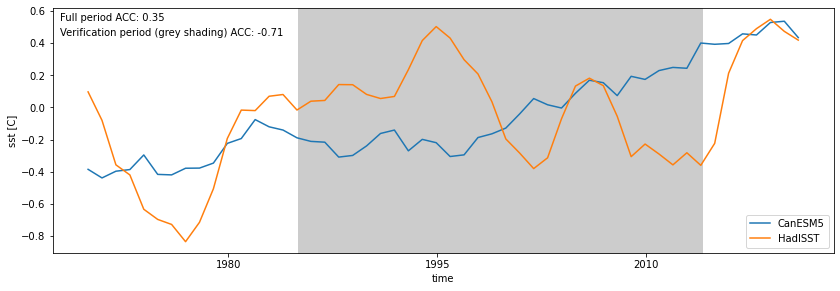

In [12]:
fig, ax = plt.subplots(figsize=(14, 4.5))

hcst.plot(label="CanESM5")
obsv.plot(label="HadISST")
ylim = plt.gca().get_ylim()
plt.fill_between(
    [cftime.datetime(1985, 1, 1), cftime.datetime(2014, 1, 1)],
    [ylim[0], ylim[0]],
    [ylim[1], ylim[1]],
    color=[0.8, 0.8, 0.8],
)
plt.gca().set_ylim(ylim)
plt.title("")
plt.legend(loc="lower right")

plt.text(
    0.01,
    0.98,
    f"Full period ACC: {acc_full_period:.2f}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax.transAxes,
)
_ = plt.text(
    0.01,
    0.92,
    f"Verification period (grey shading) ACC: {acc_verif_period:.2f}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax.transAxes,
)

### Initialised component of the anomaly correlation coefficient | HadISST 
(see https://doi.org/10.1029/2019GL086361)

In [13]:
f6_annual_ri = xr.open_zarr(
    f"{SKILL_DIR}/CAFEf6.HadISST.annual.anom_1991-2020.sst.ri_1991-2020.zarr"
).compute()

f6_4year_ri = xr.open_zarr(
    f"{SKILL_DIR}/CAFEf6.HadISST.4-year.anom_1991-2020.sst.ri_1991-2020.zarr"
).compute()

In [14]:
can_annual_ri = xr.open_zarr(
    f"{SKILL_DIR}/CanESM5.HadISST.annual.anom_1985-2014.sst.ri_1985-2014.zarr"
).compute()

can_4year_ri = xr.open_zarr(
    f"{SKILL_DIR}/CanESM5.HadISST.4-year.anom_1985-2014.sst.ri_1985-2014.zarr"
).compute()

In [15]:
ec_annual_ri = xr.open_zarr(
    f"{SKILL_DIR}/EC_Earth3.HadISST.annual.anom_1985-2014.sst.ri_1985-2014.zarr"
).compute()

ec_4year_ri = xr.open_zarr(
    f"{SKILL_DIR}/EC_Earth3.HadISST.4-year.anom_1985-2014.sst.ri_1985-2014.zarr"
).compute()

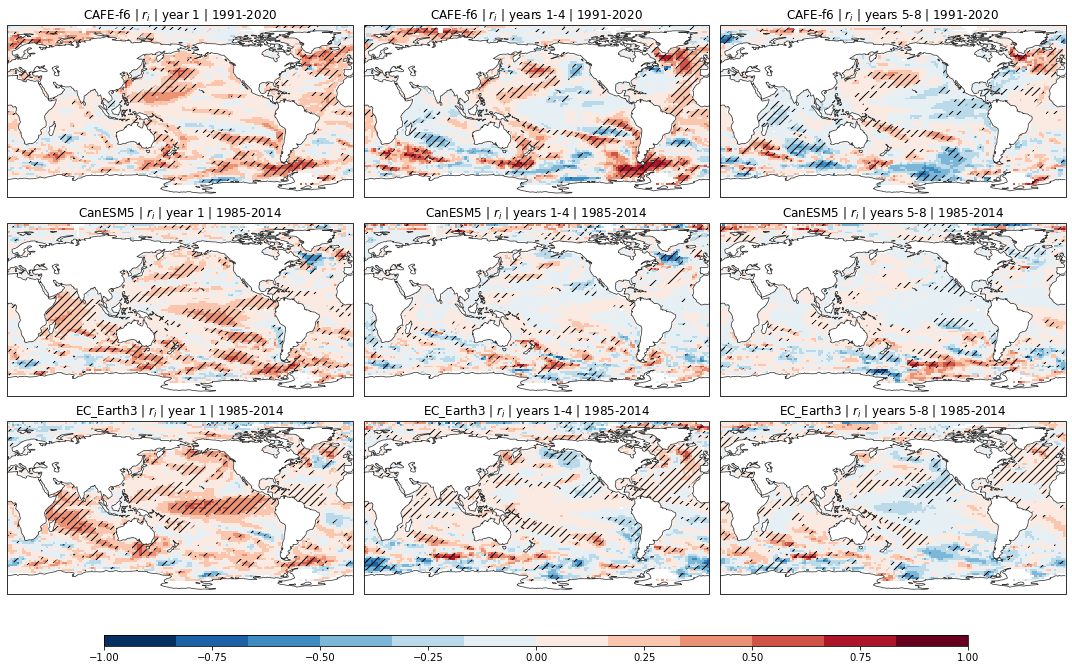

In [16]:
metric = "$r_{i}$"

_ = plot.skill_maps(
    [
        [
            f6_annual_ri.sel(lead=23),
            f6_4year_ri.sel(lead=59),
            f6_4year_ri.sel(lead=107),
        ],
        [
            can_annual_ri.sel(lead=23),
            can_4year_ri.sel(lead=59),
            can_4year_ri.sel(lead=107),
        ],
        [
            ec_annual_ri.sel(lead=23),
            ec_4year_ri.sel(lead=59),
            ec_4year_ri.sel(lead=107),
        ],
    ],
    variable="sst",
    vrange=(-1, 1),
    headings=[
        [
            f"CAFE-f6 | {metric} | year 1",
            f"CAFE-f6 | {metric} | years 1-4",
            f"CAFE-f6 | {metric} | years 5-8",
        ],
        [
            f"CanESM5 | {metric} | year 1",
            f"CanESM5 | {metric} | years 1-4",
            f"CanESM5 | {metric} | years 5-8",
        ],
        [
            f"EC_Earth3 | {metric} | year 1",
            f"EC_Earth3 | {metric} | years 1-4",
            f"EC_Earth3 | {metric} | years 5-8",
        ],
    ],
)

### Mean squared skill score relative to historical simulations | HadISST

In [17]:
f6_annual_msss = xr.open_zarr(
    f"{SKILL_DIR}/CAFEf6.HadISST.annual.anom_1991-2020.sst.MSSS_1991-2020.zarr"
).compute()

f6_4year_msss = xr.open_zarr(
    f"{SKILL_DIR}/CAFEf6.HadISST.4-year.anom_1991-2020.sst.MSSS_1991-2020.zarr"
).compute()

In [18]:
can_annual_msss = xr.open_zarr(
    f"{SKILL_DIR}/CanESM5.HadISST.annual.anom_1985-2014.sst.MSSS_1985-2014.zarr"
).compute()

can_4year_msss = xr.open_zarr(
    f"{SKILL_DIR}/CanESM5.HadISST.4-year.anom_1985-2014.sst.MSSS_1985-2014.zarr"
).compute()

In [19]:
ec_annual_msss = xr.open_zarr(
    f"{SKILL_DIR}/EC_Earth3.HadISST.annual.anom_1985-2014.sst.MSSS_1985-2014.zarr"
).compute()

ec_4year_msss = xr.open_zarr(
    f"{SKILL_DIR}/EC_Earth3.HadISST.4-year.anom_1985-2014.sst.MSSS_1985-2014.zarr"
).compute()

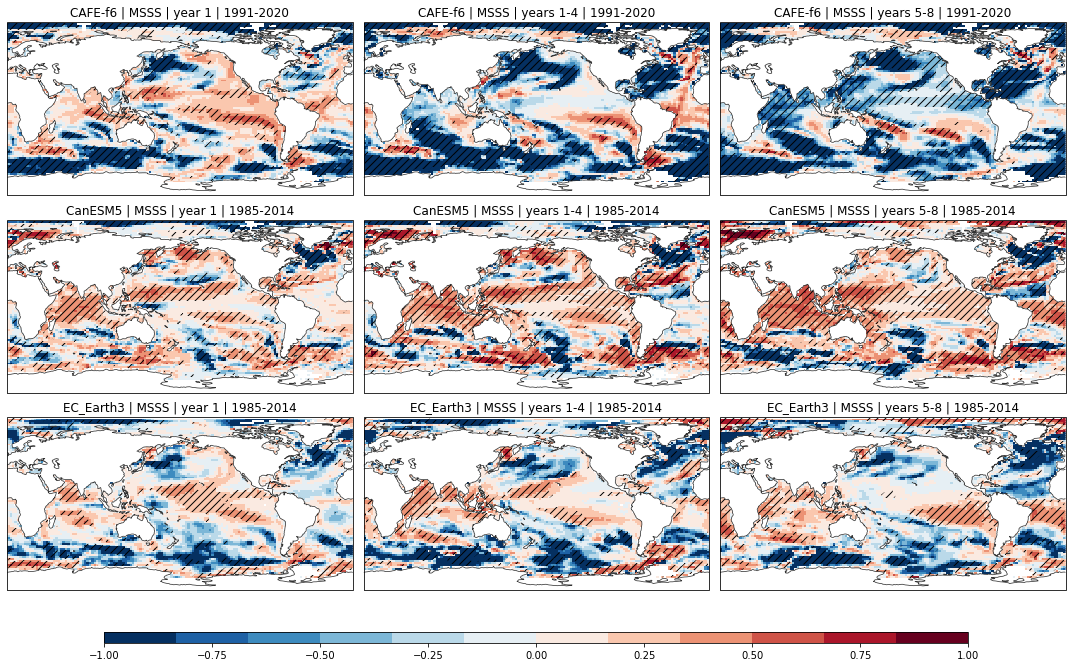

In [20]:
metric = "MSSS"

_ = plot.skill_maps(
    [
        [
            f6_annual_msss.sel(lead=23),
            f6_4year_msss.sel(lead=59),
            f6_4year_msss.sel(lead=107),
        ],
        [
            can_annual_msss.sel(lead=23),
            can_4year_msss.sel(lead=59),
            can_4year_msss.sel(lead=107),
        ],
        [
            ec_annual_msss.sel(lead=23),
            ec_4year_msss.sel(lead=59),
            ec_4year_msss.sel(lead=107),
        ],
    ],
    variable="sst",
    vrange=(-1, 1),
    headings=[
        [
            f"CAFE-f6 | {metric} | year 1",
            f"CAFE-f6 | {metric} | years 1-4",
            f"CAFE-f6 | {metric} | years 5-8",
        ],
        [
            f"CanESM5 | {metric} | year 1",
            f"CanESM5 | {metric} | years 1-4",
            f"CanESM5 | {metric} | years 5-8",
        ],
        [
            f"EC_Earth3 | {metric} | year 1",
            f"EC_Earth3 | {metric} | years 1-4",
            f"EC_Earth3 | {metric} | years 5-8",
        ],
    ],
)

### Rank probability skill score relative to historical simulations | HadISST

In [21]:
f6_annual_crpss = xr.open_zarr(
    f"{SKILL_DIR}/CAFEf6.HadISST.annual.anom_1991-2020.sst.CRPSS_1991-2020.zarr"
).compute()

f6_4year_crpss = xr.open_zarr(
    f"{SKILL_DIR}/CAFEf6.HadISST.4-year.anom_1991-2020.sst.CRPSS_1991-2020.zarr"
).compute()

In [22]:
can_annual_crpss = xr.open_zarr(
    f"{SKILL_DIR}/CanESM5.HadISST.annual.anom_1985-2014.sst.CRPSS_1985-2014.zarr"
).compute()

can_4year_crpss = xr.open_zarr(
    f"{SKILL_DIR}/CanESM5.HadISST.4-year.anom_1985-2014.sst.CRPSS_1985-2014.zarr"
).compute()

In [23]:
ec_annual_crpss = xr.open_zarr(
    f"{SKILL_DIR}/EC_Earth3.HadISST.annual.anom_1985-2014.sst.CRPSS_1985-2014.zarr"
).compute()

ec_4year_crpss = xr.open_zarr(
    f"{SKILL_DIR}/EC_Earth3.HadISST.4-year.anom_1985-2014.sst.CRPSS_1985-2014.zarr"
).compute()

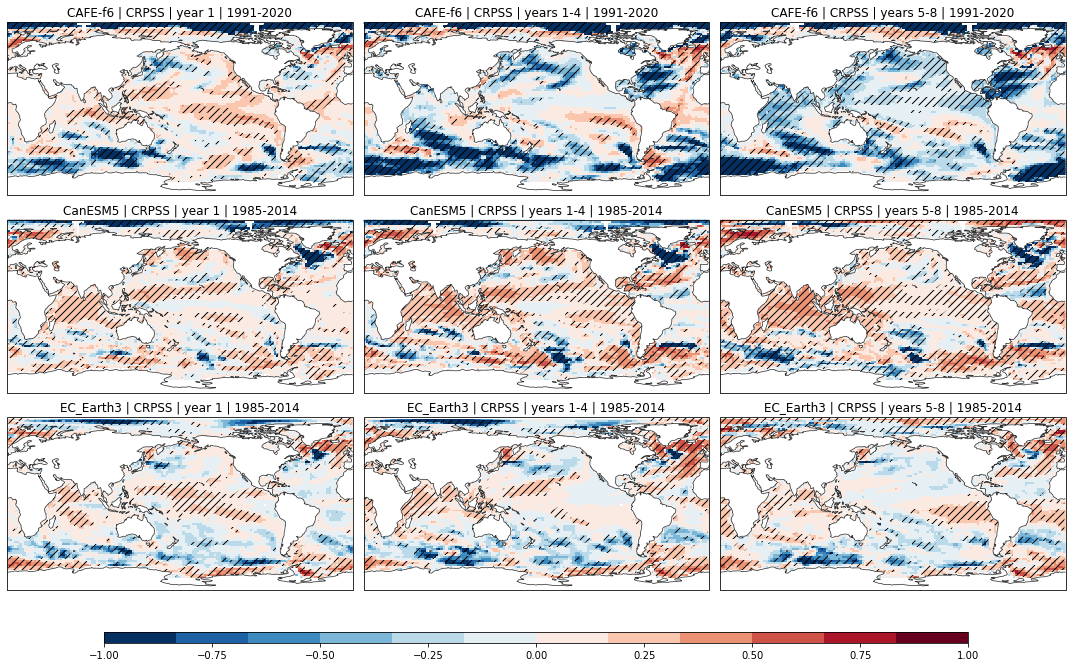

In [24]:
metric = "CRPSS"

_ = plot.skill_maps(
    [
        [
            f6_annual_crpss.sel(lead=23),
            f6_4year_crpss.sel(lead=59),
            f6_4year_crpss.sel(lead=107),
        ],
        [
            can_annual_crpss.sel(lead=23),
            can_4year_crpss.sel(lead=59),
            can_4year_crpss.sel(lead=107),
        ],
        [
            ec_annual_crpss.sel(lead=23),
            ec_4year_crpss.sel(lead=59),
            ec_4year_crpss.sel(lead=107),
        ],
    ],
    variable="sst",
    vrange=(-1, 1),
    headings=[
        [
            f"CAFE-f6 | {metric} | year 1",
            f"CAFE-f6 | {metric} | years 1-4",
            f"CAFE-f6 | {metric} | years 5-8",
        ],
        [
            f"CanESM5 | {metric} | year 1",
            f"CanESM5 | {metric} | years 1-4",
            f"CanESM5 | {metric} | years 5-8",
        ],
        [
            f"EC_Earth3 | {metric} | year 1",
            f"EC_Earth3 | {metric} | years 1-4",
            f"EC_Earth3 | {metric} | years 5-8",
        ],
    ],
)

## Near-surface (2m) temperature
### Anomaly correlation coefficient  |  JRA55

## Precipitation
### Anomaly correlation coefficient  |  GPCP

## Upper ocean heat content (upper 300m)
### Anomaly correlation coefficient  |  EN.4.2.2